### Load Modules

In [1]:
# Restart the kernel
import os
import dill as pickle
notebook_dir = os.getcwd()
current_dir ='../../../../'
os.chdir(current_dir)

In [2]:
from src.codes.basic import *
from src.codes.utils.fem_utils_StrucMech import *
from src.codes.utils.plot_files.plot_utils import OneDPlot as plot
# from src.codes.utils.plot_files.plot_utils import data_stats
from src.codes.utils.rom_utils import *
from src.codes.utils.dynamical_systems import *
import time as time

from src.codes.prob_classes.structural_mechanics.base_class_struc_mech_NL_static_axial import ROM_simulation
from src.codes.algorithms.ecsw import ecsw_red


# Third-Party Libraries for Data Handling and Visualization
import ptitprince as pt
import pandas as pd

# from importlib import reload

### Load data

In [3]:
filename_dataC = 'examples/structural_mechanics/Axial/NL_static/data/DataClass_structMech_axial.dill'

with open(filename_dataC, 'rb') as f:
    Data_cls = pickle.load(f)

In [4]:
# load required variables from data
FOS = Data_cls.FOS
d = FOS.data
mask = d.mask
param_list = np.asarray(Data_cls.param_list)
NLS = np.asarray(Data_cls.NL_solutions)
K_mus = Data_cls.K_mus
q_mus = Data_cls.q_mus

# train_mask, test_mask = Data_cls.train_mask, Data_cls.test_mask 

N_snap = len(NLS)
print(N_snap)

100


## ECSW Hyper-reduction

### Train-Test split

In [5]:
Snap_sel=100
train_mask, test_mask = train_test_split(N_snap,N_sel=Snap_sel)

### Data-processing

In [6]:
NLS_train = NLS[train_mask][:,mask]
NLS_test = NLS[test_mask][:,mask]

In [7]:
NLS_train.shape

(80, 250)

### Mean Subtraction

In [8]:
NLS_train_mean = np.mean(NLS_train,axis = 0)
NLS_train_ms = NLS_train - NLS_train_mean

### Plot snapshots

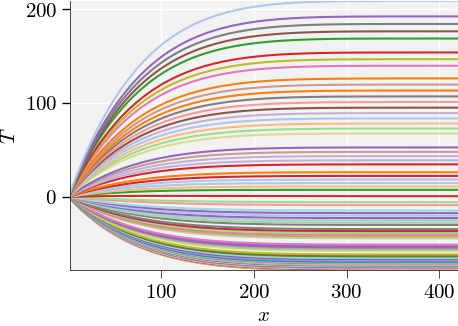

In [9]:
fig, ax = plt.subplots(figsize=(5,3.5))

for i in range(len(NLS_train_ms)):
    Plot = plot(d.xi[0][1:], NLS_train_ms[i], ax=ax)
    Plot.line_()

plt.show()


#### Step 1: Perform SVD on the snapshots (calculate $\mathbb{V}(=\mathbb{W}$)):

Number of modes selected: 3


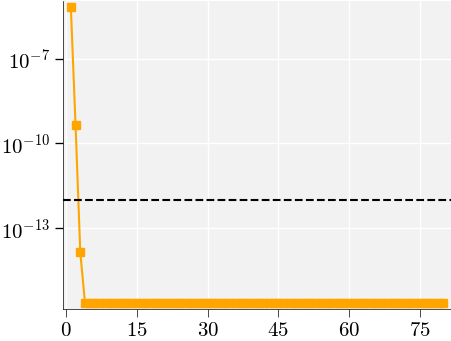

In [10]:
plt.rcParams['figure.dpi'] = 100
n_sel, U = svd_mode_selector(NLS_train_ms, tolerance=1e-12,modes=True)
n_sel +=0
V_sel = U[:, :n_sel]

In [11]:
V_sel.shape

(250, 3)

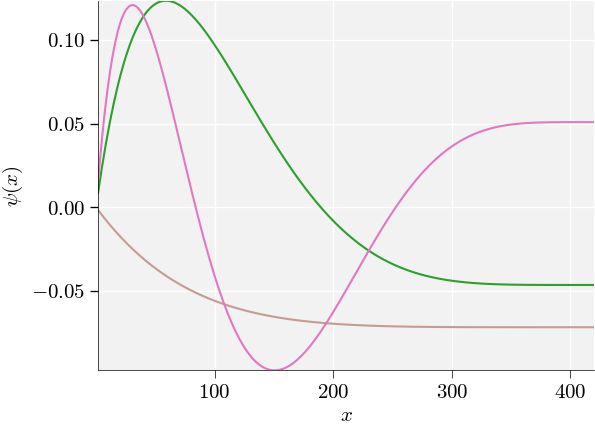

In [12]:
fig, ax = plt.subplots()

for i in range(n_sel):
    Plot = plot(d.xi[0][1:], V_sel[:,i], ax=ax)
    Plot.line_()

Plot.ax.set_xlabel('$x$')
Plot.ax.set_ylabel('$\psi(x)$')

plt.show()

### Step 2: Perform NNLS for ECSW

In [13]:
tic_h_setup_b = time.time()

tol=None

data = {'K_mus':K_mus,'q_mus':q_mus}
xi, residual = ecsw_red(d, V_sel, d.Le, data, n_sel, len(NLS_train), NLS_train, NLS_train_mean, Data_cls.FOS.residual_func, tol=tol)

toc_h_setup_b = time.time()

norm of rhs: 5.213556138770931


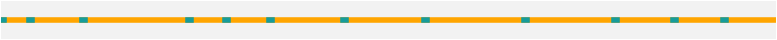

Fraction of total elements active in the ROM: 5.2%
residual=4.8012548616746225e-08


In [14]:
plot(np.arange(d.ncells[0]), xi, ax="").element_()
print(f"Fraction of total elements active in the ROM: {len(xi[xi>0])*100/len(xi)}%")
print(f"{residual=}")


### ROM Simulation

In [15]:
Data_cls.mean = NLS_train_mean

In [16]:
eval_rom = True

if eval_rom:
    ROM_h = ROM_simulation(Data_cls, NLS_test, param_list, test_mask, V_sel, xi=xi) #, N_rom_snap=1)
    ROM_h.run_simulation()

initial residual = 0.03853019680945103 

iter 0, NL residual=0.02842196421356113, delta=585.4340408500307
iter 1, NL residual=0.02123671017094459, delta=249.27464826662785
iter 2, NL residual=0.016045981136372272, delta=117.05131431493992
iter 3, NL residual=0.012238702823855325, delta=60.02814653096007
iter 4, NL residual=0.009407811107749282, delta=33.25078898657226
iter 5, NL residual=0.007277870293115058, delta=19.67200064896584
iter 6, NL residual=0.005659201590077729, delta=12.3002460326624
0 happened
iter 7, NL residual=0.004418795356784285, delta=8.051703247331828
0 happened
iter 8, NL residual=0.003461729847549403, delta=5.472687012644349
iter 9, NL residual=0.0027191533591800917, delta=3.8354981992720254
iter 10, NL residual=0.0021403884208443186, delta=2.7556273214359424
iter 11, NL residual=0.0016876524872892536, delta=2.019801158158921
iter 12, NL residual=0.0013324593833125406, delta=1.5044535144195181
iter 13, NL residual=0.0010531443819699314, delta=1.1351286193670813
i

In [17]:
if eval_rom:
    ROM = ROM_simulation(Data_cls, NLS_test, param_list, test_mask, V_sel) #, N_rom_snap=1)
    ROM.run_simulation()

initial residual = 0.03866378827671385 

iter 0, NL residual=0.028510548317594978, delta=585.4681245451357
iter 1, NL residual=0.021296415103911778, delta=249.28343915129622
iter 2, NL residual=0.016086997955881744, delta=117.05489052718816
iter 3, NL residual=0.012267453136057834, delta=60.03034036978319
iter 4, NL residual=0.009428359991436907, delta=33.25235766014267
iter 5, NL residual=0.007292820811928925, delta=19.673152558353777
iter 6, NL residual=0.005670248965584598, delta=12.301090972699862
iter 7, NL residual=0.00442706625954534, delta=8.052322254216906
iter 8, NL residual=0.0034679895718821817, delta=5.473141848991824
0 happened
iter 9, NL residual=0.0027239330486674993, delta=3.8358345147782296
iter 10, NL residual=0.0021440642380828505, delta=2.7558780094377564
iter 11, NL residual=0.0016904959314363078, delta=2.019989616300496
iter 12, NL residual=0.0013346735017058591, delta=1.5045962814227163
iter 13, NL residual=0.0010548664970324916, delta=1.1352353095163066
iter 14

### Performance Statistics

In [18]:
NLS_rom_h = np.asarray(ROM_h.NL_solutions_rom)
ROM_speed_up_h = ROM_h.speed_up
ROM_relative_error_h = ROM_h.rom_error

In [19]:
NLS_rom = np.asarray(ROM.NL_solutions_rom)
ROM_speed_up = ROM.speed_up
ROM_relative_error = ROM.rom_error

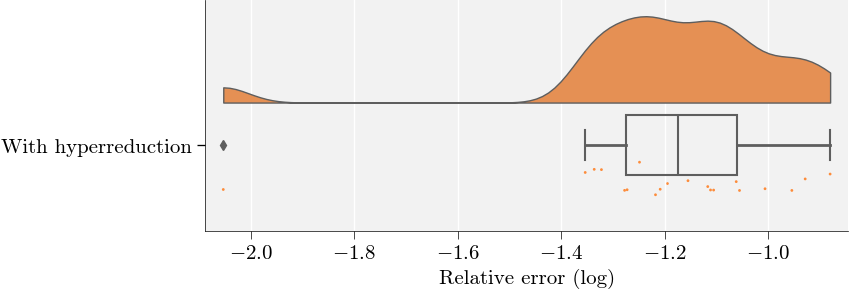

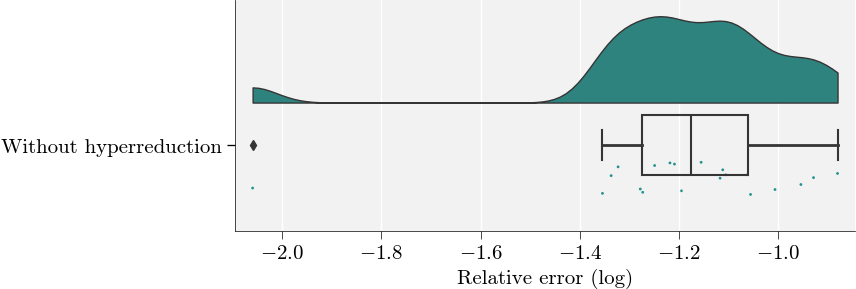

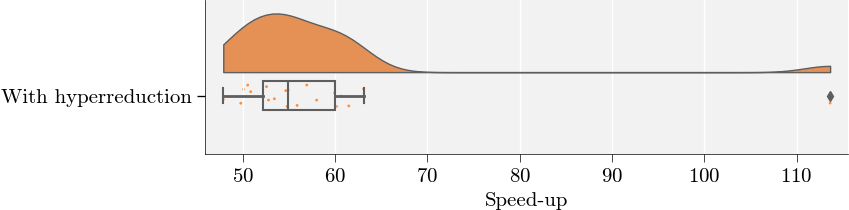

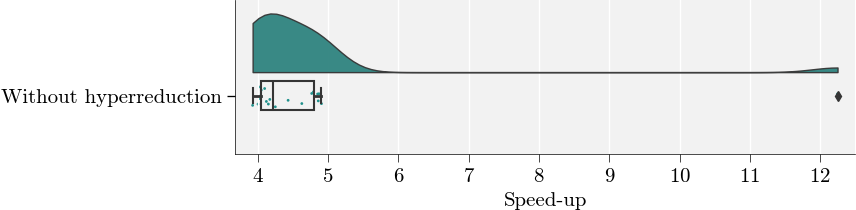

In [20]:
df_A = pd.DataFrame({'':'With hyperreduction','Relative error (log)':np.log10(ROM_relative_error_h)})
df_B = pd.DataFrame({'':'Without hyperreduction','Relative error (log)':np.log10(ROM_relative_error)})

# Combine the DataFrames
df = pd.concat([df_A, df_B])

fig, ax = plt.subplots(figsize=(8.3, 3))
pt.RainCloud(x = '', y = 'Relative error (log)', data = df_A, palette = "Oranges", bw = 0.2,
    width_viol = 1., ax = ax, orient = "h",pointplot = False, dodge=False, alpha=1.0, width_box = 0.35, linewidth=1, point_size =2.0, move=0.2)
plt.show()

fig, ax = plt.subplots(figsize=(8, 3))
pt.RainCloud(x = '', y = 'Relative error (log)', data = df_B, palette = "viridis", bw = 0.2,
    width_viol = 1., ax = ax, orient = "h",pointplot = False, dodge=False, alpha=1.0, width_box = 0.35, linewidth=1, point_size =2.0, move=0.2)
plt.show()

# ===

df_C = pd.DataFrame({'':'With hyperreduction','Speed-up':ROM_speed_up_h})
df_D = pd.DataFrame({'':'Without hyperreduction','Speed-up':ROM_speed_up})

# Combine the DataFrames
df2 = pd.concat([df_C, df_D])

fig, ax = plt.subplots(figsize=(8.3, 2))
pt.RainCloud(x = '', y = 'Speed-up', data = df_C, palette = "Oranges",
    width_viol = 1.0, ax = ax, orient = "h",pointplot = False, dodge=True, alpha=1.0, width_box = 0.25, linewidth=1, point_size =2.0)

fig, ax = plt.subplots(figsize=(8, 2))
pt.RainCloud(x = '', y = 'Speed-up', data = df_D, palette = "viridis",
    width_viol = 1.0, ax = ax, orient = "h",pointplot = False, dodge=True, alpha=0.95, width_box = 0.25, linewidth=1, point_size =2.0)
plt.show()

---

## Aleatoric Uncertainty

### Different distributions of parameters

In [ ]:
nk_small = 10
nq_small = 10

In [ ]:
nk_bulk = 20000
nq_bulk = 20000

In [ ]:
gaussian = False
lognormal = True
uniform = False
exponential = False
gamma = False

##### Gussian distribution

In [ ]:
if gaussian:
    mean_k, mean_q = 0, 0
    sd_k, sd_q = 0.4, 10

    def gaussian_params(mean_k,sd_k,nk,mean_q,sd_q,nq):
        # num_snapshots = nk*nq
        k_param = np.random.normal(mean_k, sd_k, nk) #np.linspace(-0.5, 0.5, nk)
        q_param = np.random.normal(mean_q,sd_q,nq)

        params = np.column_stack((k_param, q_param))
        
        return params

    params = gaussian_params(mean_k,sd_k,nk_small,mean_q,sd_q,nq_small)
    uq_params = gaussian_params(mean_k,sd_k,nk_bulk,mean_q,sd_q,nq_bulk)

##### Uniform distribution 

In [ ]:
if uniform:
    
    sd_k, sd_q = 0.4, 40

    def uniform_params(sd_k,nk,sd_q,nq):
        # num_snapshots = nk*nq
        k_param = np.random.uniform(-sd_k,sd_k,nk) #np.linspace(-0.5, 0.5, nk)
        q_param = np.random.normal(-sd_q,sd_q,nq)

        params = np.column_stack((k_param, q_param))
        
        return params

    params = uniform_params(sd_k,nk_small,sd_q,nq_small)
    uq_params = uniform_params(sd_k,nk_bulk,sd_q,nq_bulk)

##### Lognormal distribution

In [ ]:
if lognormal:

    mu_k, mu_q = -2, -0.1  # Mean of the logarithmic values
    sd_k, sd_q = 0.1, 40

    def lognormal_params(mu_k,sd_k,nk,mu_q,sd_q,nq):
         
        # Calculate necessary sigma
        # Rearrange the formula for standard deviation of lognormal distribution to solve for sigma
        sigma_k = np.sqrt(np.log((sd_k**2) / (np.exp(2 * mu_k) + sd_k**2) + 1))
        sigma_q = np.sqrt(np.log((sd_q**2) / (np.exp(2 * mu_q) + sd_q**2) + 1))

        k_param = np.random.lognormal(mean=mu_k, sigma=sigma_k, size=nk)
        q_param = np.random.lognormal(mean=mu_q, sigma=sigma_q, size=nq)

        params = np.column_stack((k_param, q_param))

        return params


    params = lognormal_params(mu_k,sd_k,nk_small,mu_q,sd_q,nq_small)
    uq_params = lognormal_params(mu_k,sd_k,nk_bulk,mu_q,sd_q,nq_bulk)

##### Exponential Distribution

In [ ]:
if exponential:

    mu_k, mu_q = 15, 0.2  # Mean of the logarithmic values
    sd_k, sd_q = 0.4, 40

    def exponential_params(mu_k,sd_k,nk,mu_q,sd_q,nq):

        k_param = np.random.exponential(1/mu_k, nk)
        k_param = k_param[k_param <= sd_k]

        q_param = np.random.exponential(1/mu_q, nq)
        q_param = q_param[q_param <= sd_q]

            # Ensure both arrays have the same length (by limiting to the smaller size)
        min_length = min(len(k_param), len(q_param))
        k_param = k_param[:min_length]
        q_param = q_param[:min_length]

        params = np.column_stack((k_param, q_param))

        return params

    params = exponential_params(mu_k,sd_k,nk_small,mu_q,sd_q,nq_small)
    uq_params = exponential_params(mu_k,sd_k,nk_bulk,mu_q,sd_q,nq_bulk)

##### Gamma Distribution

In [ ]:
if gamma:

    def gamma_params(mu_k, sd_k, nk, mu_q, sd_q, nq, bound_k, bound_q):

        # Calculate shape and scale from pseudo mean and sd
        shape_k = (mu_k ** 2) / (sd_k ** 2)
        scale_k = (sd_k ** 2) / mu_k
        shape_q = (mu_q ** 2) / (sd_q ** 2)
        scale_q = (sd_q ** 2) / mu_q
        
        # Generate gamma samples
        k_param = np.random.gamma(shape_k, scale_k, nk)
        q_param = np.random.gamma(shape_q, scale_q, nq)
        
        # Truncate samples
        k_param = k_param[k_param <= bound_k]
        q_param = q_param[q_param <= bound_q]
        
        # Ensure both arrays have the same length (by limiting to the smaller size)
        min_length = min(len(k_param), len(q_param))
        k_param = k_param[:min_length]
        q_param = q_param[:min_length]
        
        # Stack parameters together
        params = np.column_stack((k_param, q_param))
        
        return params


    # Example usage:
    nk_small, nq_small = 10, 10
    mu_k, sd_k, bound_k = 0.1, 0.1, 0.4  # Pseudo mean, sd, and truncation bound for k
    mu_q, sd_q, bound_q = 30, 40, 50.0  # Pseudo mean, sd, and truncation bound for q

    params = gamma_params(mu_k, sd_k, nk_small, mu_q, sd_q, nq_small, bound_k, bound_q)
    uq_params = gamma_params(mu_k, sd_k, nk_bulk, mu_q, sd_q, nq_bulk, bound_k, bound_q)

##### Visualize

##### $k$

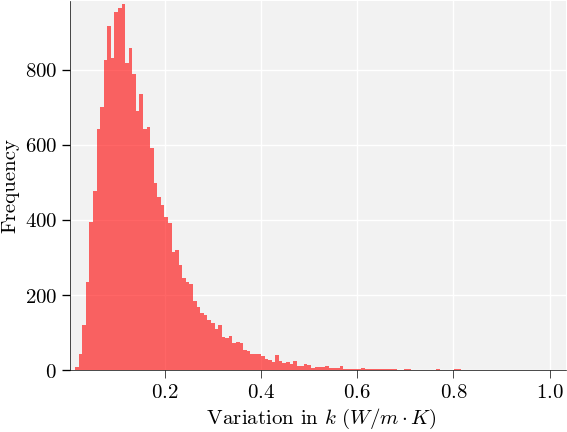

In [ ]:
plt.hist(uq_params[:,0], bins='auto', density=False, alpha=0.6, color='r')
plt.xlabel(' Variation in $k~(W/m\cdot K)$')
plt.ylabel('Frequency')
plt.show()

<Axes: xlabel='Variation in $k~(W/m\\cdot K)$'>

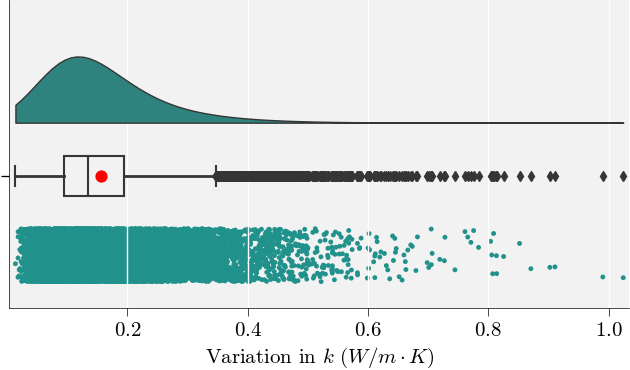

In [ ]:
import pandas as pd
import ptitprince as pt

df = pd.DataFrame({'':'','Variation in $k~(W/m\cdot K)$':uq_params[:,0]})

# Initialize the figure and axes for the first plot (a2 coefficients)
fig, ax1 = plt.subplots(figsize=(8,4))

# Initialize the figure and axes for the second plot (a3 coefficients)
# fig, ax2 = plt.subplots(figsize=(8,4))

pt.RainCloud(
    data=df, # DataFrame: Contains the data for plotting.
    x='', # str: Column name for the categorical variable.
    y='Variation in $k~(W/m\cdot K)$', # str: Column name for the continuous variable.
    hue=None, # str, optional: Categorical variable for color coding points.
    order=None, # list, optional: Specific order for the categorical levels.
    hue_order=None, # list, optional: Specific order for the hue levels.
    palette='viridis', # list or dict: Color settings for each category or hue.
    bw=.5, # float: Bandwidth for kernel density estimation.
    width_viol=0.5, # float: Width of the violin part.
    ax=ax1, # Axes: Specific matplotlib axes to draw on.
    orient="h", # str: Plot orientation ('h' for horizontal, 'v' for vertical).
    alpha=1.0, # float: Transparency level for the density and scatter plots.
    dodge=True, # bool: Adjust points to avoid overlap.
    pointplot=True, # bool: Overlay a point plot on the raincloud plot.
    point_size=3.5, # float: Size of points in the scatter plot.
    scale='count', # str: Method to scale the width of the violins ('area', 'count', or 'width').
    jitter=1, # float: Width of the jitter for the scatter points.
    move=0.3 # float: Horizontal adjustment of the plot elements.
)

##### $q$

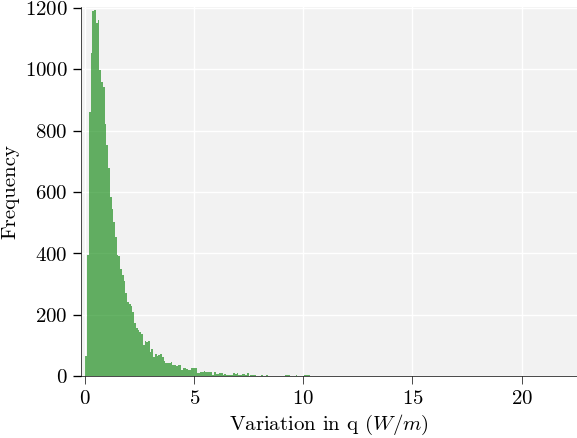

In [ ]:
plt.hist(uq_params[:,1], bins='auto', density=False, alpha=0.6, color='g')
plt.xlabel('Variation in q $(W/m)$')
plt.ylabel('Frequency')
plt.show()

<Axes: xlabel='Variation in q $(W/m)$'>

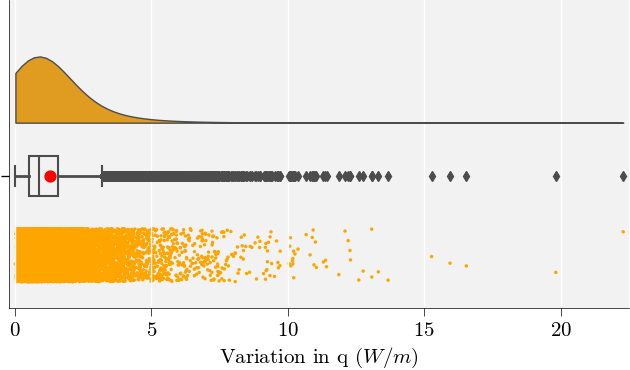

In [ ]:
df = pd.DataFrame({'':'','Variation in q $(W/m)$':uq_params[:,1]})

# Initialize the figure and axes for the first plot (a2 coefficients)
fig, ax1 = plt.subplots(figsize=(8,4))

# Initialize the figure and axes for the second plot (a3 coefficients)
# fig, ax2 = plt.subplots(figsize=(8,4))
# palette = 
pt.RainCloud(
    data=df, # DataFrame: Contains the data for plotting.
    x='', # str: Column name for the categorical variable.
    y='Variation in q $(W/m)$', # str: Column name for the continuous variable.
    hue=None, # str, optional: Categorical variable for color coding points.
    order=None, # list, optional: Specific order for the categorical levels.
    hue_order=None, # list, optional: Specific order for the hue levels.
    palette=['#ffa500'], # list or dict: Color settings for each category or hue.
    bw=.8, # float: Bandwidth for kernel density estimation.
    width_viol=0.5, # float: Width of the violin part.
    ax=ax1, # Axes: Specific matplotlib axes to draw on.
    orient="h", # str: Plot orientation ('h' for horizontal, 'v' for vertical).
    alpha=1.0, # float: Transparency level for the density and scatter plots.
    dodge=True, # bool: Adjust points to avoid overlap.
    pointplot=True, # bool: Overlay a point plot on the raincloud plot.
    point_size=2.5, # float: Size of points in the scatter plot.
    scale='count', # str: Method to scale the width of the violins ('area', 'count', or 'width').
    jitter=1, # float: Width of the jitter for the scatter points.
    move=0.3 # float: Horizontal adjustment of the plot elements.
)

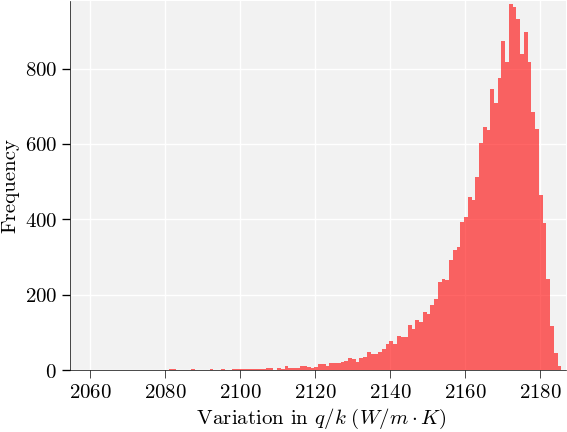

In [ ]:
plt.hist((uq_params[:,1]+35000)/(16+uq_params[:,0]), bins='auto', density=False, alpha=0.6, color='r')
plt.xlabel(' Variation in $q/k~(W/m\cdot K)$')
plt.ylabel('Frequency')
plt.show()

<Axes: xlabel='Variation in q/k'>

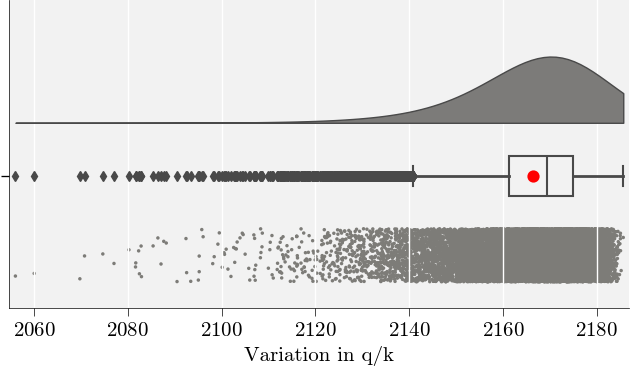

In [ ]:
df5 = pd.DataFrame({'':'','Variation in q/k':(uq_params[:,1]+35000)/(16+uq_params[:,0])})

# Initialize the figure and axes for the first plot (a2 coefficients)
fig, ax1 = plt.subplots(figsize=(8,4))

# Initialize the figure and axes for the second plot (a3 coefficients)
# fig, ax2 = plt.subplots(figsize=(8,4))
# palette = 
pt.RainCloud(
    data=df5, # DataFrame: Contains the data for plotting.
    x='', # str: Column name for the categorical variable.
    y='Variation in q/k', # str: Column name for the continuous variable.
    hue=None, # str, optional: Categorical variable for color coding points.
    order=None, # list, optional: Specific order for the categorical levels.
    hue_order=None, # list, optional: Specific order for the hue levels.
    palette='cividis', # list or dict: Color settings for each category or hue.
    bw=.8, # float: Bandwidth for kernel density estimation.
    width_viol=0.5, # float: Width of the violin part.
    ax=ax1, # Axes: Specific matplotlib axes to draw on.
    orient="h", # str: Plot orientation ('h' for horizontal, 'v' for vertical).
    alpha=1.0, # float: Transparency level for the density and scatter plots.
    dodge=True, # bool: Adjust points to avoid overlap.
    pointplot=True, # bool: Overlay a point plot on the raincloud plot.
    point_size=2.5, # float: Size of points in the scatter plot.
    scale='count', # str: Method to scale the width of the violins ('area', 'count', or 'width').
    jitter=1, # float: Width of the jitter for the scatter points.
    move=0.3 # float: Horizontal adjustment of the plot elements.
)

##### Using FOM

In [ ]:
import numpy as np
from tests.UQ.FEM_1D_data_gen_UQ import UQ_data_gen
from src.codes.prob_classes.base_class_heat_conduction import ROM_simulation_exec
# Step 2: Modify the parameter
# Specify mean and standard deviation

generate = True
filename_dataC = 'tests\\UQ\\data\\DataClass_UQ_L.dill'   


if(generate):
    tic = time.time()
    UQ_data_gen(params,filename_dataC)
    toc = time.time()
    fom_time = toc-tic

Snap 0
Snap 1
Snap 2
Snap 3
Snap 4
Snap 5
Snap 6
Snap 7
Snap 8
Snap 9
Simulation data saved


##### Using hyperROM

In [ ]:
with open(filename_dataC, 'rb') as g:
    Data_cls_UQ = pickle.load(g)

In [ ]:
NLS_UQ = np.asarray(Data_cls_UQ.NL_solutions)
d = Data_cls_UQ.FOS.data
UQ_data = NLS_UQ[:,d.mask]
# ==

tic_rom = time.time()
# p_UQ = np.append(Data_cls_UQ.param_list[:-1],mean)
p_UQ = Data_cls_UQ.param_list[:-1]

ROM_h_UQ = ROM_simulation_exec(Data_cls, UQ_data, p_UQ, V_sel, xi=xi) #, N_rom_snap=1)
# ROM_h_UQ = ROM_simulation_exec(Data_cls, NLS_test, param_list[test_mask], V_sel, xi=xi)
ROM_h_UQ.run_simulation_h_ecsw()

toc_rom = time.time()
rom_time = toc_rom-tic_rom

In [ ]:
NLS_rom_h_UQ = np.asarray(ROM_h_UQ.NL_solutions_rom)
ROM_relative_error_h_UQ = ROM_h_UQ.rom_error

### Comparison

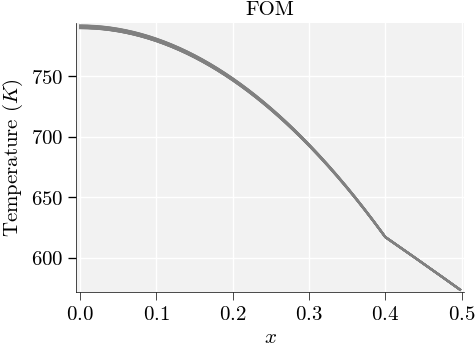

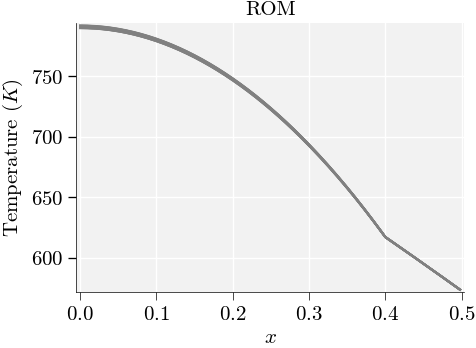

In [ ]:
color = "grey"  # This could also be a hex code or RGB tuple

# FOM
fig, ax = plt.subplots(figsize=(5,3.5))
for i in range(UQ_data.shape[0]):
    ax.plot(d.xi[0][d.mask], UQ_data[i], color=color)

# ax.plot(d.xi[0][d.mask], UQ_data[-1], color='red')
ax.set_title(f"FOM")
ax.set_xlabel('$x$')
ax.set_ylabel('Temperature $(K)$')
plt.show()

# ROM
fig, ax = plt.subplots(figsize=(5,3.5))
for i in range(NLS_rom_h_UQ.shape[0]):
    ax.plot(d.xi[0][d.mask], NLS_rom_h_UQ[i][d.mask], color=color)

# params==Data_cls_UQ.param_list
# ax.plot(d.xi[0][d.mask], NLS_rom_h_UQ[-1][d.mask], color='red')
ax.set_title('ROM')
ax.set_xlabel('$x$')
ax.set_ylabel('Temperature $(K)$')
plt.show()

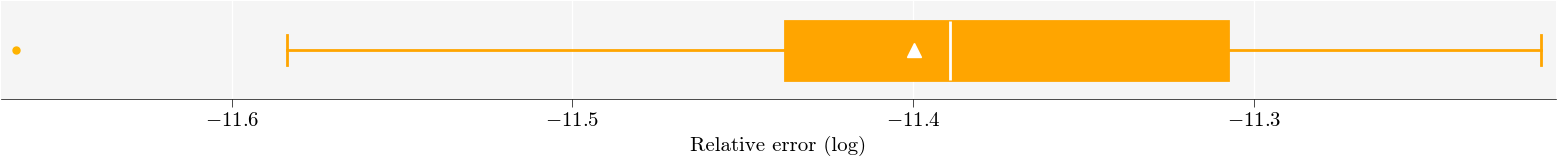

58.048902424715465


In [ ]:
from src.codes.utils.plot_files.plot_utils import data_stats
data_stats(np.log10(np.array(ROM_relative_error_h_UQ)), show_histogram=False, show_boxplot=True, show_mean_std=True, xlabel="Relative error (log)", ylabel="Frequency");
print(fom_time/rom_time)

#### UQ with HyperROM

In [ ]:
tic_rom = time.time()

ROM_h_UQ = ROM_simulation_exec(Data_cls, UQ_data, uq_params, V_sel, xi=xi, fos_comp= False) #, N_rom_snap=1)
# ROM_h_UQ = ROM_simulation_exec(Data_cls, NLS_test, param_list[test_mask], V_sel, xi=xi)
ROM_h_UQ.run_simulation_h_ecsw()

toc_rom = time.time()

rom_time = toc_rom-tic_rom

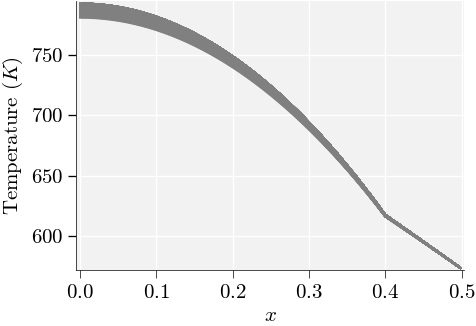

In [ ]:
# ROM
NLS_rom_h_UQ = np.asarray(ROM_h_UQ.NL_solutions_rom)

fig, ax = plt.subplots(figsize=(5,3.5))
for i in range(NLS_rom_h_UQ.shape[0]-1):
    ax.plot(d.xi[0][d.mask], NLS_rom_h_UQ[i][d.mask], color=color)

# params==Data_cls_UQ.param_list
# ax.plot(d.xi[0][d.mask], NLS_rom_h_UQ[-1][d.mask], color='red')
ax.set_xlabel('$x$')
ax.set_ylabel('Temperature $(K)$')

plt.show()

In [ ]:
data_at_x_p1 = NLS_rom_h_UQ[:,50]

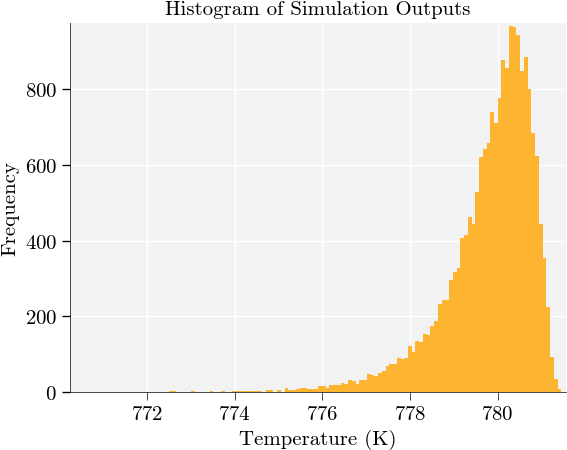

In [ ]:
from scipy.stats import iqr

bin_width = 2 * iqr(data_at_x_p1) / (len(data_at_x_p1) ** (1 / 3))  # Freedman-Diaconis Rule
bins = np.arange(min(data_at_x_p1), max(data_at_x_p1) + bin_width, bin_width)

plt.hist(data_at_x_p1, bins=bins, density=False, alpha=0.8, color='orange')
plt.title('Histogram of Simulation Outputs')
plt.xlabel('Temperature (K)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
from scipy.stats import skew, kurtosis

# Calculating statistics for each row
mean = np.mean(data_at_x_p1)
std_dev = np.std(data_at_x_p1)
skewneys = skew(data_at_x_p1)
kurtosees = kurtosis(data_at_x_p1)

# Example: print statistics for the first row of outputs
print("Mean:", mean)
print("Standard Deviation:", std_dev)
print("Skewness:", skewneys)
print("Kurtosis:", kurtosees)


Mean: 779.8012470624416
Standard Deviation: 1.0362006700398596
Skewness: -1.7811389261136963
Kurtosis: 5.576382505054125


<Axes: xlabel='Distribution of temperature (K)'>

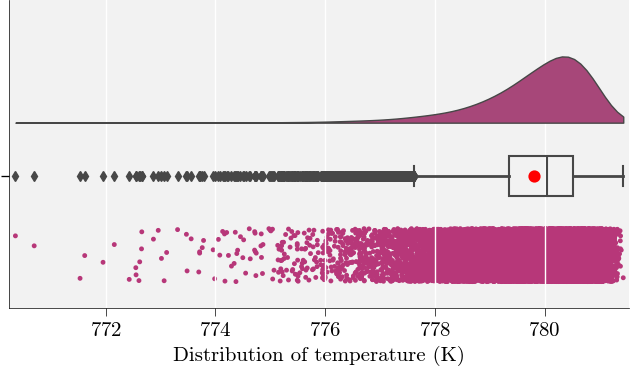

In [ ]:
import pandas as pd
import ptitprince as pt

df = pd.DataFrame({'':'','Distribution of temperature (K)':data_at_x_p1})

# Initialize the figure and axes for the first plot (a2 coefficients)
fig, ax1 = plt.subplots(figsize=(8,4))

# Initialize the figure and axes for the second plot (a3 coefficients)
# fig, ax2 = plt.subplots(figsize=(8,4))

pt.RainCloud(
    data=df, # DataFrame: Contains the data for plotting.
    x='', # str: Column name for the categorical variable.
    y='Distribution of temperature (K)', # str: Column name for the continuous variable.
    hue=None, # str, optional: Categorical variable for color coding points.
    order=None, # list, optional: Specific order for the categorical levels.
    hue_order=None, # list, optional: Specific order for the hue levels.
    palette='magma', # list or dict: Color settings for each category or hue.
    bw=.25, # float: Bandwidth for kernel density estimation.
    width_viol=0.5, # float: Width of the violin part.
    ax=ax1, # Axes: Specific matplotlib axes to draw on.
    orient="h", # str: Plot orientation ('h' for horizontal, 'v' for vertical).
    alpha=1.0, # float: Transparency level for the density and scatter plots.
    dodge=True, # bool: Adjust points to avoid overlap.
    pointplot=True, # bool: Overlay a point plot on the raincloud plot.
    point_size=3.5, # float: Size of points in the scatter plot.
    scale='count', # str: Method to scale the width of the violins ('area', 'count', or 'width').
    jitter=1, # float: Width of the jitter for the scatter points.
    move=0.3 # float: Horizontal adjustment of the plot elements.
)